In [1]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import interp1d

# Overview
This is the looped version of "Experiment COA - Image". Instead of finding the contact angle for just one frame, the contact angles are found and stored for all frames. 

# 1) Data Load

In [3]:
data = scipy.io.loadmat('C:\\Users\josep\Desktop\Summer Research Project\processed_edges_Matlab.mat') 

# Extract the frames 
processed_edges = data['processedEdges'] 

In [5]:
processed_edges[0,0].shape

(1080, 1721)

In [7]:
no_frames = processed_edges.shape[1]
no_frames

690

# 2) Input Manually

## 2.1) Halfway Line

In [9]:
half_line_y = 587.5 
# at what value do you define the halfway line between the reflection 

In [11]:
i = 600
# test a random frame

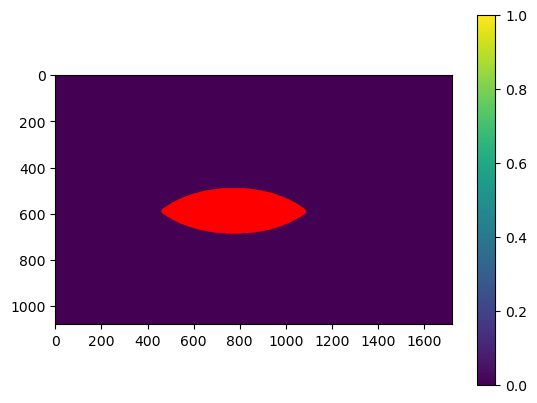

In [13]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()

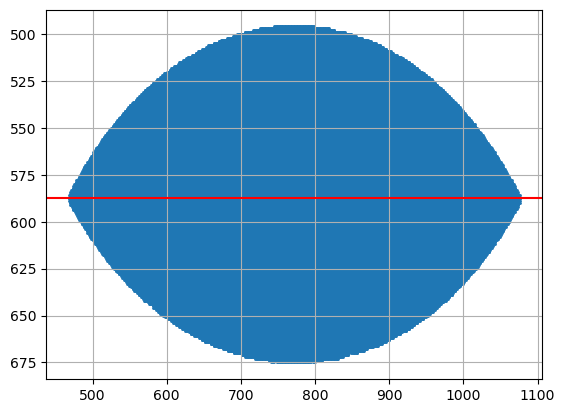

In [15]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()

# Draw the horizontal line at 230
plt.axhline(y=half_line_y, color='r', linestyle='-')


#plt.ylim(599,580)
#plt.xlim(520, 720)
plt.show()

# 3) Define Functions

In [18]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    
    Parameters:
    x_edge (list): List of x coordinates.
    y_edge (list): List of y coordinates.
    target_y (int or float): The y value to filter the x values.
    """
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]

    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

# 4) Perform Loop

## 4.1) Left Angle

In [22]:
angles_list = []
i_left_list = []

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    # this condition is imposed to ensure only frames with more than 5000 points are used
    if len(x) < 5000 or 587 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = (-np.min(x_upper) + np.max(x_upper)) / 4 + np.min(x_upper)
        quarter_mask = [x_upper <= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        points = np.vstack((x_filtered, y_filtered)).T

        # Convex Hull
        alpha = 0.1 
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape.geoms:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
            # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
            
            x_at_max_y = poly(max_y_point)
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        '''Find the contact angle'''

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_left<0:
            angle = np.abs(angle_tangent_degrees_left)
        
        if angle_tangent_degrees_left>0:
            angle = 180 - angle_tangent_degrees_left

        angles_list.append(angle)
        i_left_list.append(i)

100%|██████████| 690/690 [12:43<00:00,  1.11s/it]


In [23]:
i_left = np.array(i_left_list)

In [24]:
angle_left = np.array(angles_list)
angle_left

array([ 33.30267365, 114.86410509, 124.88560918, 116.35305694,
        23.96248897,  41.50937285, 115.45411368, 116.33847832,
       117.50159183, 109.2743508 , 116.46683976, 108.75937977,
       115.99159699, 117.55361421,  90.22942027,  89.79283671,
        90.39096933,  77.71250753,  84.09090595,  75.62636147,
        60.29416994,  55.5340361 ,  43.75019903,  41.24254963,
        41.69653945,  22.43460616,  25.96545445,  28.05727267,
        28.03343052,  28.63275215,  56.32235651,  45.30425793,
        27.7952864 ,  27.71478219,  19.98494009,  46.85211059,
        38.14108937,  13.79458799,  17.39388018,   9.0825422 ,
         8.98631267,  13.583604  ,  12.04049715,  14.53027934,
        13.47704581,  13.396133  ,  12.81092185,  10.44430055,
        10.13446465,  11.8487523 ,  12.17332393, 116.58579125,
         5.60894749,   9.3082342 ,  20.21886667,  22.74047545,
        12.5909294 ,  15.22386922,  15.57295872,  13.90008789,
        14.02513432,  13.36406087,  17.20829077,   9.63

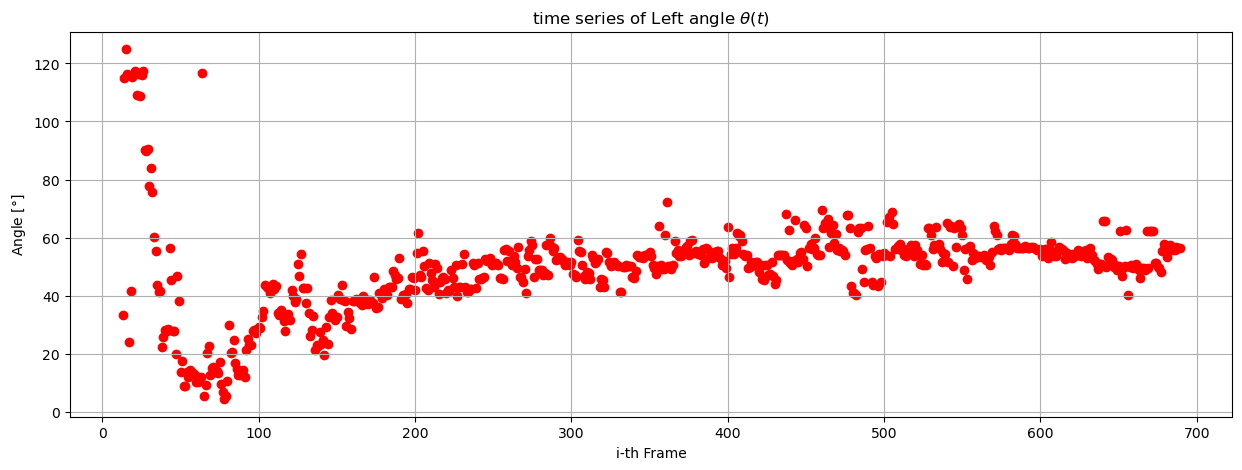

In [25]:
plt.figure(figsize=(15,5))
plt.scatter(i_left, angle_left, color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Left angle $\\theta(t)$")
plt.grid(True)

## 4.2) Right Angle

In [26]:
angles_list = []
i_right_list = []

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 5000 or 587 not in y:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = -(-np.min(x_upper) + np.max(x_upper)) / 4 + np.max(x_upper)
        quarter_mask = [x_upper >= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_right  = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_right < 0:
            angle = 180 + angle_tangent_degrees_right
        
        if angle_tangent_degrees_right > 0:
            angle = angle_tangent_degrees_right

        angles_list.append(angle)
        i_right_list.append(i)

100%|██████████| 690/690 [13:29<00:00,  1.17s/it]


In [27]:
i_right = np.array(i_right_list)
i_right.shape

(677,)

In [28]:
angle_right = np.array(angles_list)
angle_right.shape

(677,)

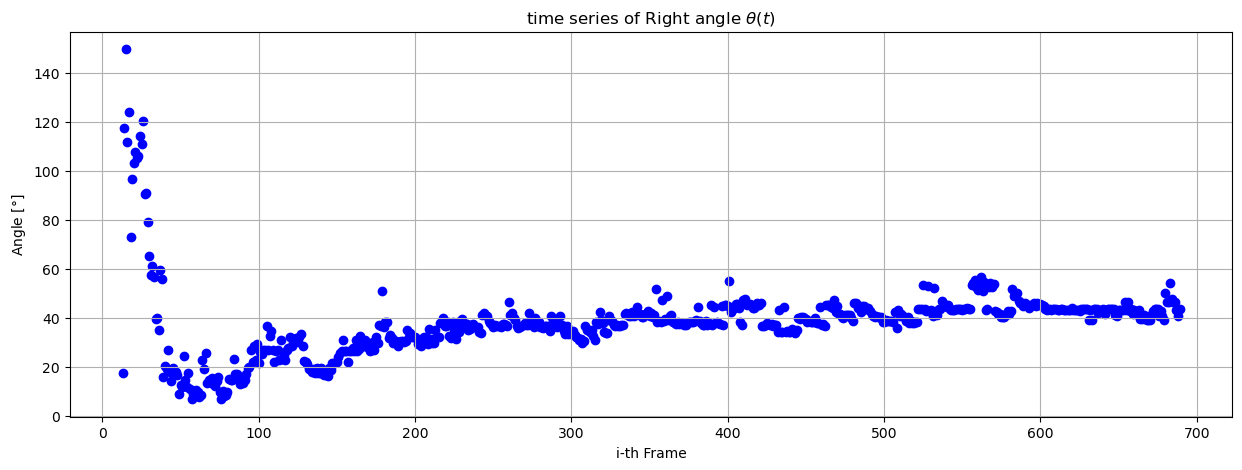

In [29]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, angle_right, color = 'blue')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Right angle $\\theta(t)$")
plt.grid(True)

# 4.3) Compare 

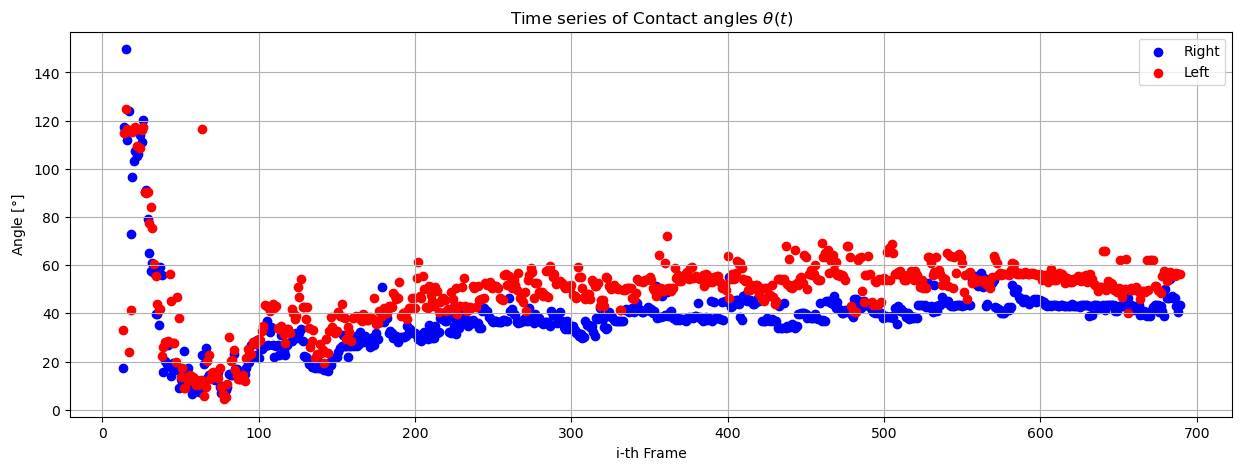

In [35]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, angle_right, label = 'Right', color = 'blue')
plt.scatter(i_left, angle_left, label = 'Left', color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("Time series of Contact angles $\\theta (t)$")
plt.grid(True)
plt.legend()

In [37]:
last_20 = np.concatenate((angle_right[-20:], angle_left[-20:]))

In [39]:
theta_e = np.mean(last_20)
theta_e
# equilibrium theta

49.75595204870761